In [1]:
%matplotlib notebook

import time
from matplotlib import pyplot as plt
from astropy.io import fits
import numpy as np
import copy
from astropy.convolution import convolve
from astropy.convolution import Gaussian1DKernel
from scipy.special import erf
from scipy.stats import sigmaclip
from scipy.optimize import minimize
import emcee
import pandas as pd
import warnings
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec 
from scipy.stats import truncnorm
from scipy.stats import skew
from scipy.stats import kurtosis
import tqdm
import init_cfg as ic

In [2]:
# ----- Basic parameters ----- #
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
redshift = ic.redshift
dist_lum = cosmo.luminosity_distance(redshift).value*1.0e+6    # pc


# ----- Reading the cube ----- #
fin_cb = 'bfcube_3D.fits'

hd0 = fits.getheader(fin_cb, ext=0)
d_sci, h_sci = fits.getdata(fin_cb, ext=1, header=True)
d_var, h_var = fits.getdata(fin_cb, ext=2, header=True)

wav = np.linspace(start=h_sci['CRVAL3']+(1-h_sci['CRPIX3'])*h_sci['CD3_3'],
                  stop=h_sci['CRVAL3']+(h_sci['NAXIS3']-h_sci['CRPIX3'])*h_sci['CD3_3'],
                  num=h_sci['NAXIS3'], endpoint=True)

wav_obs = wav

d_sci_sb = copy.deepcopy(d_sci)
d_var_sb = copy.deepcopy(d_var)

d_sci_sb[:, 0, :] = 0.
d_sci_sb[:, :, 0] = 0.
d_sci_sb[:, -1, :] = 0.
d_sci_sb[:, :, -1] = 0.

In [3]:
# ----- Creating maximum & circular spectrum ----- #
wavcut = fits.getdata("diagram/wavcut_Halpha+NII.fits")
yInd, xInd = np.unravel_index(np.argmax(wavcut), wavcut.shape)

print(f"Maximum intensity at (x, y) = ({xInd:d}, {yInd:d})")

maximum_spectrum = d_sci_sb[:, yInd, xInd]
maximum_variance = d_var_sb[:, yInd, xInd]

from photutils.aperture import CircularAperture as CAp
rad = 4
ap = CAp((xInd, yInd), r=rad)
ap_msk = ap.to_mask(method='exact')
msk = ap_msk.to_image((d_sci.shape[1], d_sci.shape[2]))
print(f"Area: {np.sum(msk):.4f} = {np.pi*rad**2:.4f}? ", np.sum(msk) == np.pi*rad**2)

circular_spectrum = np.sum(d_sci_sb*msk, axis=(1, 2))
circular_variance = np.sum(d_var_sb*msk, axis=(1, 2))
print(circular_spectrum.shape)

Maximum intensity at (x, y) = (32, 21)
Area: 50.2655 = 50.2655?  False
(5001,)


<IPython.core.display.Javascript object>


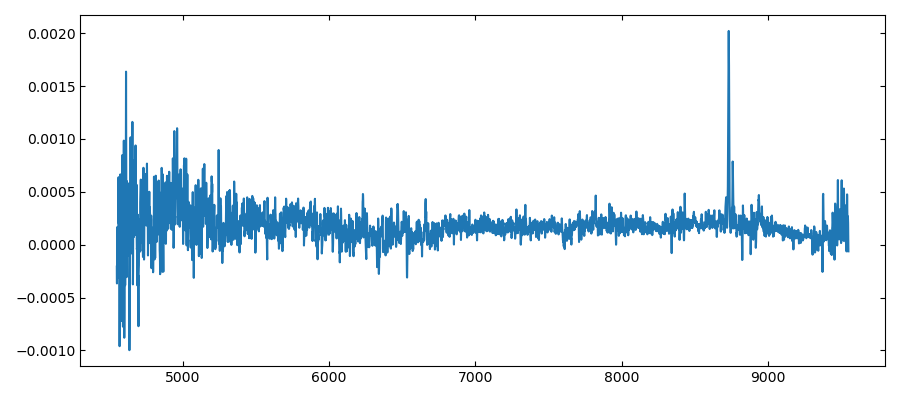

In [4]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_obs, maximum_spectrum)
plt.tight_layout()

<IPython.core.display.Javascript object>


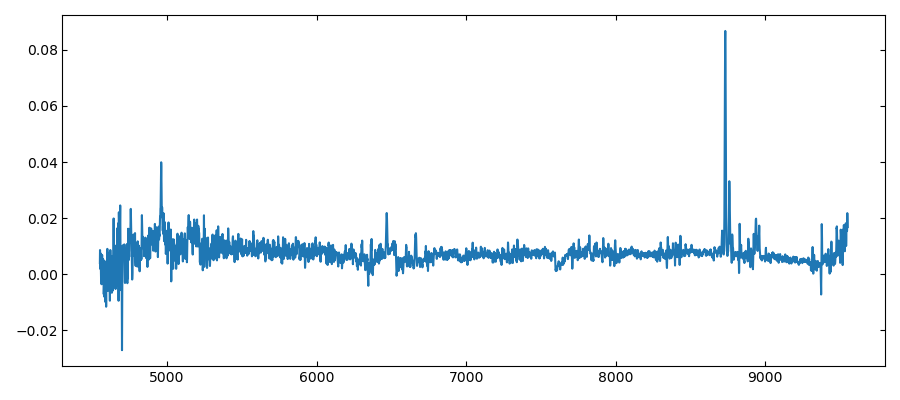

In [5]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_obs, circular_spectrum)
plt.tight_layout()

In [6]:
test_spectrum = circular_spectrum
test_variance = circular_variance

In [7]:
cont_width = 20  # AA
kernel_width = 10  # AA
sig1, sig2 = 3.0, 4.0  # For sigma clipping

<IPython.core.display.Javascript object>


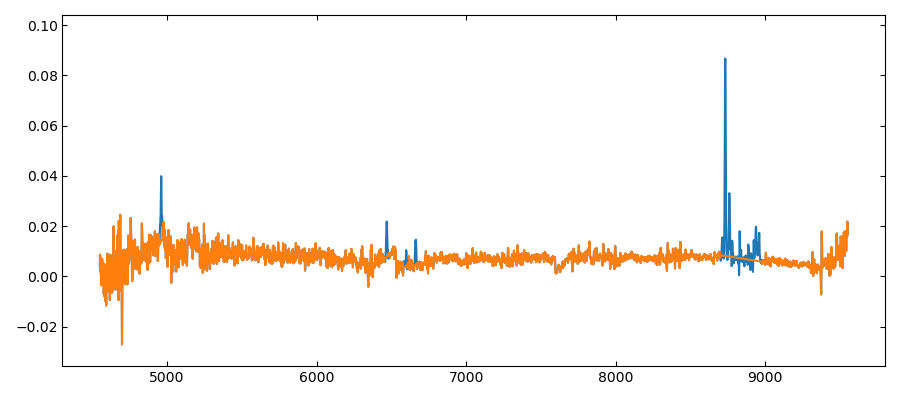

----- 0.0540 sec -----


In [8]:
time0 = time.time()

# Wavelength masking range
wav_msk = np.array([[4950, 4970],  # [OII]3727/3729
                    [6455, 6480],  # H beta
                    [6580, 6605],  # [OIII]4959
                    [6650, 6670],  # [OIII]5007
                    [8700, 8975]])  # H alpha + [NII]6548/84 + [SII]6717/31
 
# Interpolation
spec_int = copy.deepcopy(test_spectrum)
for i in np.arange(wav_msk.shape[0]):
    spx_l = np.abs(wav_obs - wav_msk[i,0]).argmin()
    spx_r = np.abs(wav_obs - wav_msk[i,1]).argmin()

    c_l, lo_l, up_l = sigmaclip(spec_int[spx_l-round(cont_width/ic.wav_intv):spx_l], sig1, sig1)  # 20 AA
    c_r, lo_r, up_r = sigmaclip(spec_int[spx_r+1:spx_r+1+round(cont_width/ic.wav_intv)], sig1, sig1)  # 20 AA

    cont_l = c_l.mean()
    cont_r = c_r.mean()
    
#     spec_int[spx_l:spx_r+1] = 0.5*(cont_l + cont_r)
    spec_int[spx_l:spx_r+1] = cont_l + \
    ((cont_r-cont_l)/(wav_obs[spx_r]-wav_obs[spx_l]))*(wav_obs[spx_l:spx_r+1]-wav_obs[spx_l])

fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_obs, test_spectrum)
ax.plot(wav_obs, spec_int)
ax.set_ylim([test_spectrum.min()-0.1*test_spectrum.max(), 1.2*test_spectrum.max()])
plt.tight_layout()

print(f"----- {time.time()-time0:.4f} sec -----")

<IPython.core.display.Javascript object>


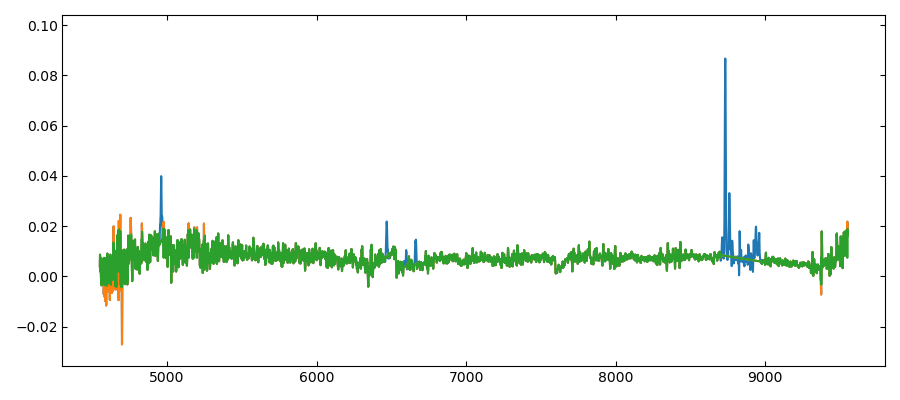

In [9]:
# Sigma clipping
from scipy.stats import sigmaclip
clipped, lower, upper = sigmaclip(spec_int, sig2, sig2)
spec_int_clipped = copy.deepcopy(spec_int)
spec_int_clipped[spec_int < lower] = clipped.mean()
spec_int_clipped[spec_int > upper] = clipped.mean()

fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_obs, test_spectrum)
ax.plot(wav_obs, spec_int)
ax.plot(wav_obs, spec_int_clipped)
ax.set_ylim([test_spectrum.min()-0.1*test_spectrum.max(), 1.2*test_spectrum.max()])
plt.tight_layout()

<IPython.core.display.Javascript object>


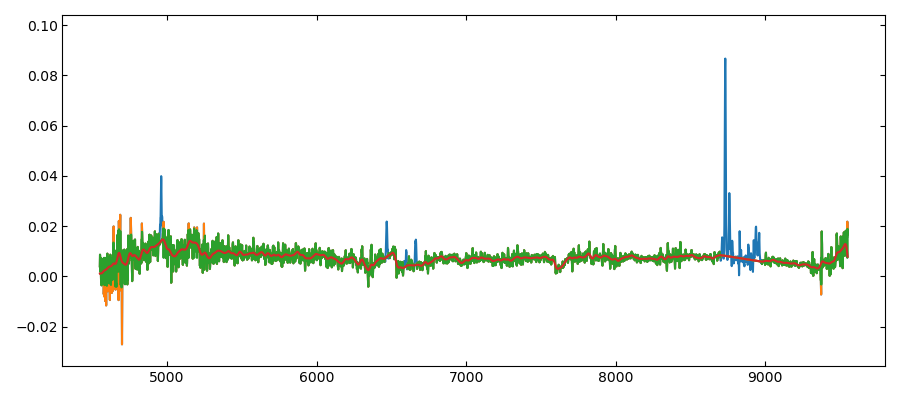

In [10]:
# Smoothing spectra
g = Gaussian1DKernel(stddev = round(kernel_width/ic.wav_intv))  # 10 AA
spec_filt = convolve(spec_int_clipped, g)  # spec_int OR spec_int_clipped

fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_obs, test_spectrum)
ax.plot(wav_obs, spec_int)
ax.plot(wav_obs, spec_int_clipped)
ax.plot(wav_obs, spec_filt)
ax.set_ylim([test_spectrum.min()-0.1*test_spectrum.max(), 1.2*test_spectrum.max()])
plt.tight_layout()

<IPython.core.display.Javascript object>


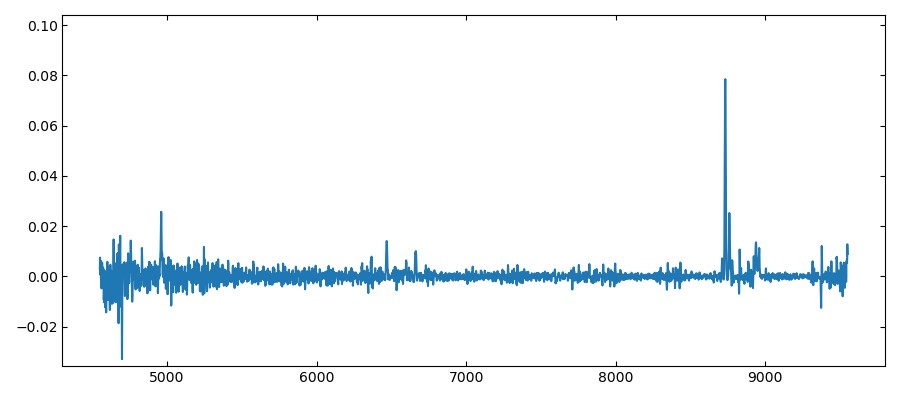

In [11]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_obs, test_spectrum - spec_filt)
ax.set_ylim([test_spectrum.min()-0.1*test_spectrum.max(), 1.2*test_spectrum.max()])
plt.tight_layout()